In [1]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.simulations.swissroll import get_swiss_roll_data, get_swiss_roll_gradients
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.utils.replicates import Replicate
from montlake.statistics.normalization import normalize_L212
from montlake.gradients.estimate import get_grads_pullback
from megaman.embedding import LTSA
from megaman.embedding import Isomap
from megaman.embedding import SpectralEmbedding
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# diffusion_time = 1
# dim = 1
# import numpy as np
# (diffusion_time * (diffusion_time * np.pi * 4)**(dim/2))**(0.5)

In [3]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0., rotate = True, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

In [4]:
n_components = 2
b = 49
d = 2
# ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=geom)
# embed_ltsa = ltsa.fit_transform(data)
# isomap_embedding = Isomap(n_components=n_components,eigen_solver='arpack',geom=geom)
# embed_isomap = isomap_embedding.fit_transform(data)
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [5]:
nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    

In [6]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)


initializing lambda search
converged 10.001168850399415
0 5.000584425199707 probe
converged 5.000584425199707
we did it [0 1]


In [7]:
import matplotlib
from montlake.plotting.plotting import plot_reg_path_ax_lambdasearch_customcolors_names
m = 2
colors = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])


In [8]:
replicates[r].get_ordered_axes()

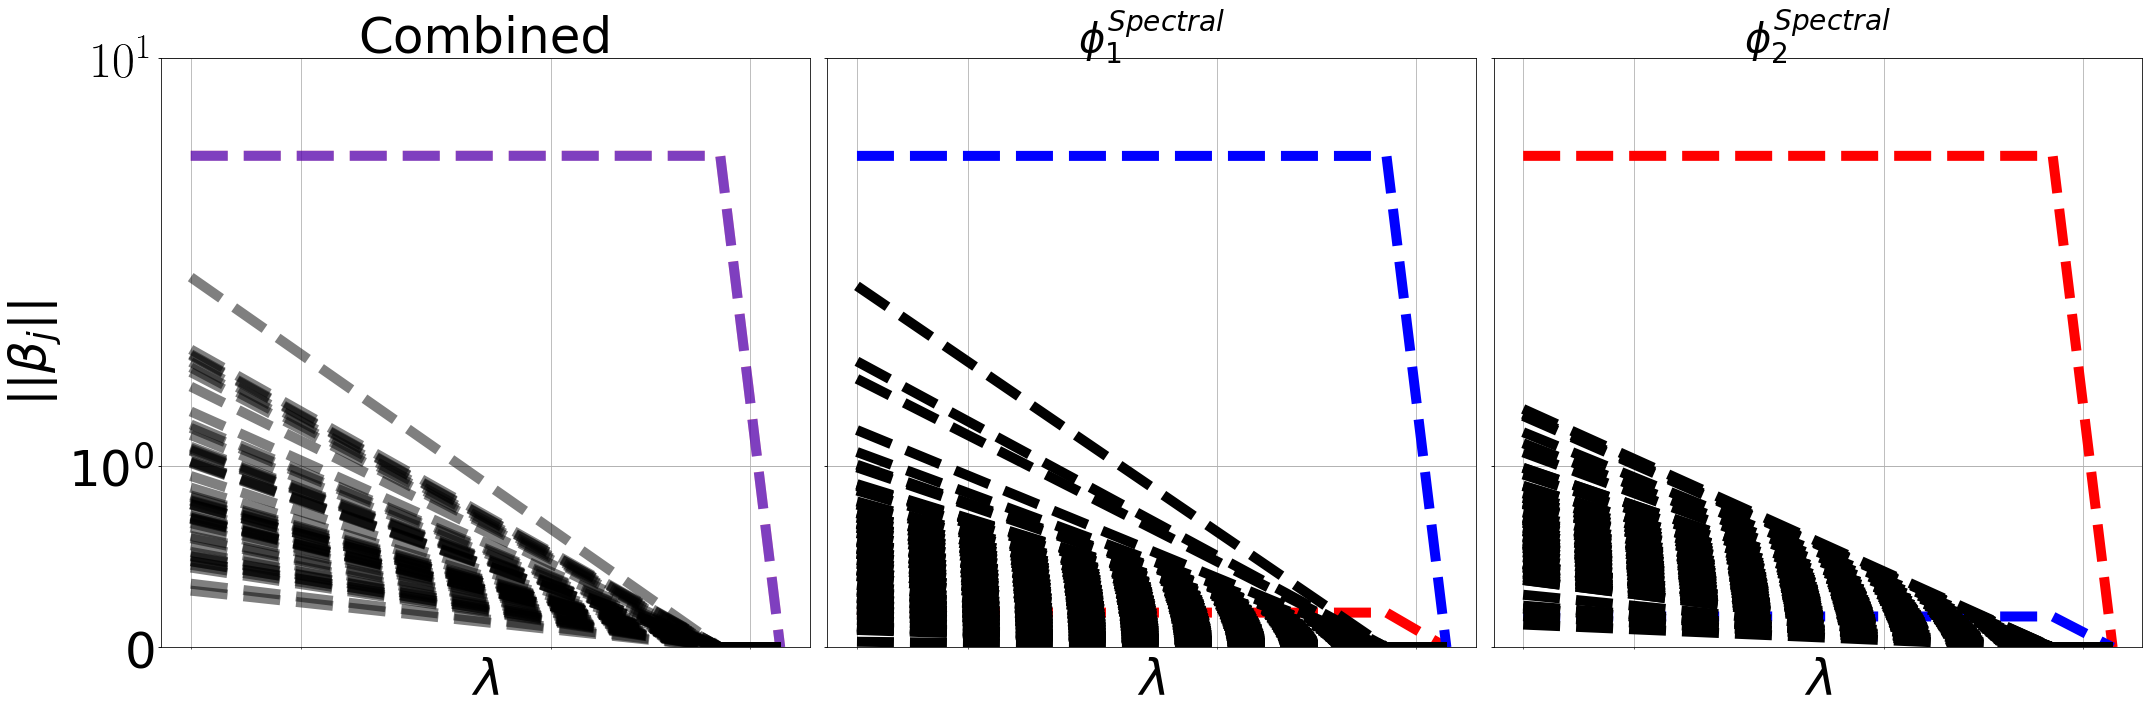

In [9]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

In [15]:
def get_grad(t):
    output = np.zeros((49,2))
    output[0,0] = ((np.cos(t) - t*np.sin(t)) / (np.sin(t) + t*np.cos(t)))
    output[2,0] = 1.
    output[1,1] = 1.
    output = output / np.linalg.norm(output, axis = 0)
    return(output)

In [ ]:
selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100


print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
# pcor = Pool(cores)
# results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate), batch_stream(replicates))




results_internal = {}
results_isomap = {}
results_ltsa = {}

ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_internal[r].df_M , replicates_internal[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_internal[r].results = get_sr_lambda_sam_parallel(replicates_internal[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_ltsa[r].df_M , replicates_ltsa[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_ltsa[r].results = get_sr_lambda_sam_parallel(replicates_ltsa[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates_isomap[r].df_M , replicates_isomap[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
replicates_isomap[r].results = get_sr_lambda_sam_parallel(replicates_isomap[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


In [13]:
data = data
embedding = embed_spectral
tangent_bases_M = replicates[r].tangent_bases_M
tangent_bases_N = replicates[r].tangent_bases_phi
selected_points = replicates[r].selected_points

affinity_matrix = geom.affinity_matrix
m = embedding.shape[1]
d = tangent_bases_M.shape[2]
nsel = selected_points.shape[0]
dF = np.zeros((nsel, d, m))


for i in range(nsel):
    pt = selected_points[i]
    neighborspt = affinity_matrix[pt].indices
    deltap0 = data[neighborspt, :] - data[pt, :]
    deltaq0 = embedding[neighborspt, :] - embedding[pt, :]
    projected_M = np.einsum('b d, i b -> i d', tangent_bases_M[i], deltap0)
    tangent_bases_N_outer = np.einsum('m d,  n d ->  m n', tangent_bases_N[i], tangent_bases_N[i])
    projected_N = np.einsum('m n, i n -> i m', tangent_bases_N_outer, deltaq0)
    lr = LinearRegression()
    lr.fit(projected_M, projected_N)
    #weights = affinity_matrix[selectedpoints[i]].data
    #lr.fit(projected_M, projected_N, weights)
    dF[i] = lr.coef_#np.linalg.lstsq(projected_M, deltaq0)[0]


NameError: name 'LinearRegression' is not defined

In [8]:
tangent_bases_M.shape

(100, 49, 2)

In [11]:
tangent_bases_N.shape

(10000, 2, 2)

In [12]:
replicates[r].tangent_bases_phi.shape

(10000, 2, 2)

In [11]:
replicates[r].dg_x.shape

(100, 49, 2)

In [10]:
norms.shape,X.shape

((49,), (100, 49, 2))

In [ ]:
from megaman.geometry import RiemannMetric
from einops import rearrange
import numpy as np
rmetric = RiemannMetric(embedding,geom.laplacian_matrix,n_dim=d)
rmetric.get_rmetric()
tangent_bases = rearrange(rmetric.Hvv,'i b1 b2 -> i b2 b1')

In [26]:
embedding.shape

(10000, 2)

In [ ]:
#no 'manifold_lasso' algorithm because we reuse substeps like tangent spaces and gradients

In [18]:
rmetric.Hvv.shape

(10000, 2, 2)

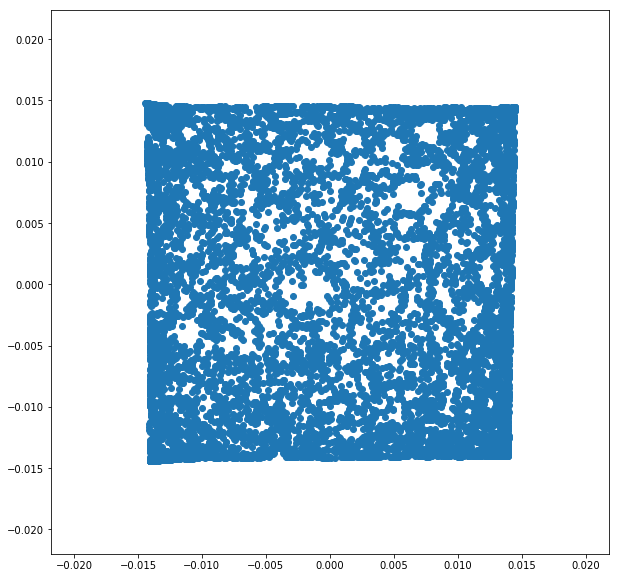

In [18]:
%matplotlib inline
embedding = embed_spectral
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')


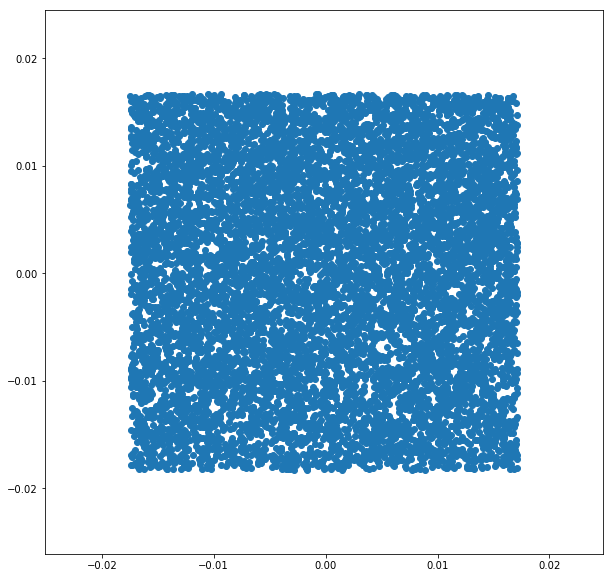

In [21]:
%matplotlib inline
embedding = embed_ltsa
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')


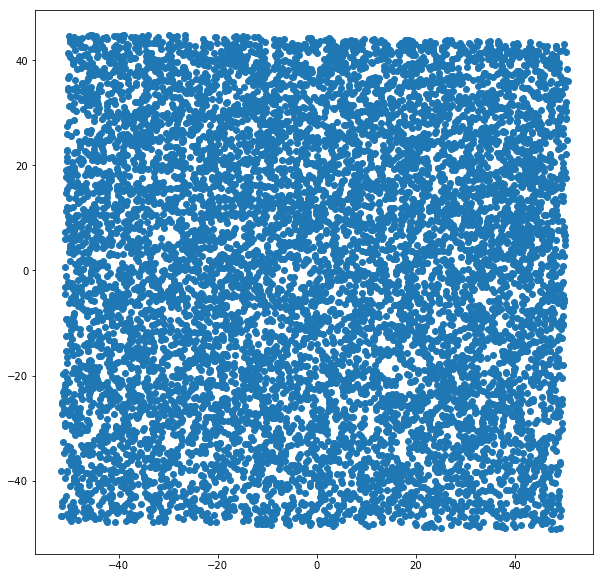

In [22]:
%matplotlib inline
embedding = embed_isomap
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')


In [23]:
%matplotlib inline
embedding = embed_internal
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')


NameError: name 'embed_internal' is not defined

In [15]:
embed_spectral

array([[ 0.00485671, -0.01334188],
       [-0.00695931, -0.01413535],
       [ 0.00242504, -0.01402916],
       ...,
       [-0.01406825, -0.01426264],
       [-0.00102656, -0.01411881],
       [-0.01385484, -0.01318446]])

In [ ]:
embed_ltsa = ltsa.fit_transform(experiment.M.data)
embed_isomap = isomap.fit_transform(experiment.M.data)

embed_internal = np.asarray([ts , ys]).transpose()

In [ ]:
gradients = get_swiss_roll_gradients(data, replicates[i].selected_points)


In [ ]:
nreps = 15
for i in range(nreps):
    print(i)
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0])

In [ ]:
nreps = 15
for i in range(nreps):
    print(i)
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0])
    replicates[i].ids,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, replicates[i].selected_points,experiment.svd, experiment.atoms4, natoms)


In [ ]:
%matplotlib inline
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )

names = [r'$\phi_1^{DM}$', r'$\phi_2^{DM}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_spectral[0].cs_reorder, replicates_spectral[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors,names)
#axes_all.colorbar('off')
#plt.tight_layout()

plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_spectral_mflasso', bbox_inches = "tight")
